# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

In [2]:
import numpy as np

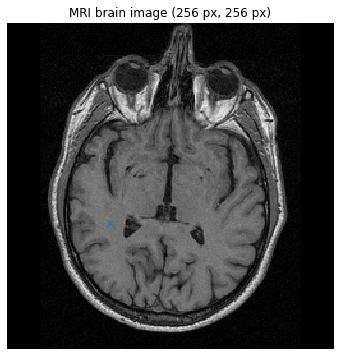

In [3]:
import skimage.io, skimage.measure
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.plot([80],[157], marker="x")
plt.show()

### 1.2 Region growing
We implement region growing by first thresholding the image (this replaces the homogeneity criterion), and then growing the region starting from an origin point manually selected.

First, threshold the image:

In [5]:
# Manually chosen point of reference in the brain region
orig = [157, 80]
# reference intensity around this point
base_lev = np.mean(brain_im[152:162,75:85])
thresh = 20
# min_thresh = base_lev - 30
# max_thresh = base_lev + 20

# threshold image around reference intensity
mask = np.logical_and(brain_im >= base_lev - thresh, brain_im <= base_lev + thresh)


Display the thresholded image:

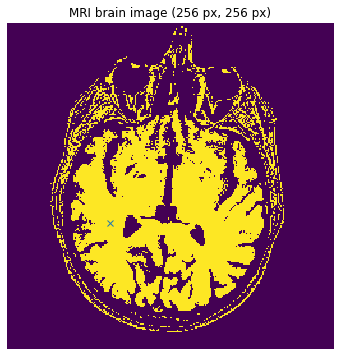

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.imshow(mask)
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.plot([orig[1]],[orig[0]], marker="x")
plt.show()

Now, grow region starting from reference point:

In [7]:
to_be_explored = [tuple(orig)]
explored = set()
brain = set()
while len(to_be_explored):
    i,j = to_be_explored.pop()
    explored.add((i,j))
    if not (min_thresh <= brain_im[i,j] <= max_thresh):
        continue
    brain.add((i,j))
    if i > 0:
        if (i-1, j) not in explored:
            to_be_explored.append((i-1, j))
    if j > 0:
        if (i, j-1) not in explored:
            to_be_explored.append((i, j-1))
    if i < 255:
        if (i+1, j) not in explored:
            to_be_explored.append((i+1, j))
    if j < 255:
        if (i, j+1) not in explored:
            to_be_explored.append((i, j+1))

print("Nb of pixels in brain:", len(brain)) 


brain_mask = np.array(([[(i,j) in brain for j in range(256)] for i in range(256)]))

Nb of pixels in brain: 16085


Display the grown brain region:

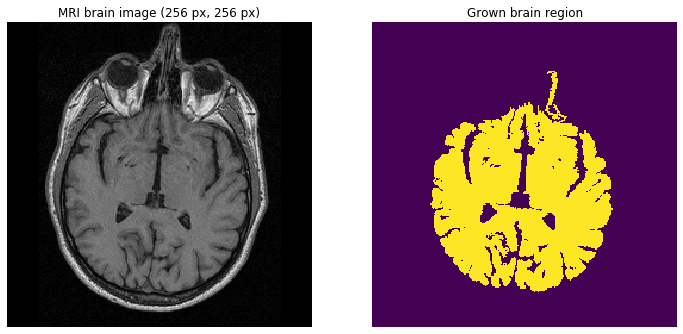

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# display original image
axs[0].imshow(brain_im, cmap='gray')
axs[0].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
axs[0].axis('off')

# display grown brain region
axs[1].imshow(brain_mask)
axs[1].set_title('Grown brain region')
axs[1].axis('off')

plt.show()

As we can see, the brain is almost perfect but for a small region between the nose and eye. Let's look at this region in more detail.

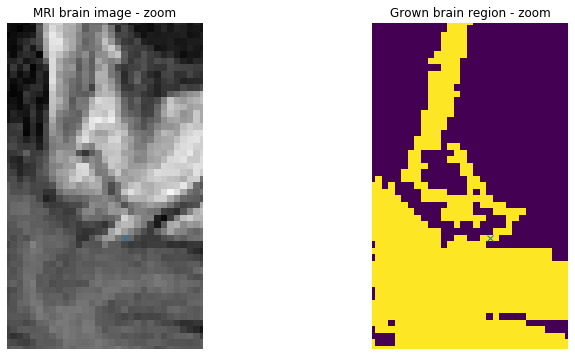

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# display original image
axs[0].imshow(brain_im, cmap='gray')
axs[0].set_title('MRI brain image - zoom')
axs[0].plot([158], [83], marker='x')
axs[0].axis('off')
axs[0].set_xlim((140, 170))
axs[0].set_ylim((100, 50))

# display grown brain region
axs[1].imshow(brain_mask)
axs[1].set_title('Grown brain region - zoom')
axs[1].plot([158], [83], marker='x')
axs[1].axis('off')
axs[1].set_xlim((140, 170))
axs[1].set_ylim((100, 50))

plt.show()

Apparently this extra region added to the brain is due to one single pixel that connects it to the brain.

This problem might possibly be removed by tuning the threshold, but this would have to be done by hand and would not be robust.

However, knowing the structure of the brain, it is reasonable to suppose that the brain is only made of (relatively) thick parts. Therefore we can decide that any pixel that is the only connection between two regions of the brain should be removed, thus disconnecting the regions.

To implement this, we use the function skimage.measure.label, which labels each pixel with a region id (one region id per connected region of equal values).
We try removing each pixel of the brain, and count the connected regions resulting from this removal. If one additional region is created by removing the pixel, then the pixel is permanently removed from the brain.
Finally we keep only the main brain region (the one that contains the reference point).

In [17]:
# function that counts the number of connected regions:
def nb_labels(mask):
    ls = set()
    labs = skimage.measure.label(mask)
    for l in (j for line in labs for j in line):
        ls.add(l)
    return len(ls)

In [19]:
# copy the brain mask
brain_mask_connected = np.array([[v for v in line] for line in brain_mask])
nb_labels(brain_mask_connected)

2

So far their are only two regions (brain and non-brain).

Now we remove from brain_mask_connected the pixels that connect two distinct regions.

In [21]:
for (i,j) in brain:
    save_val = brain_mask[i,j]
    # try removing pixel (i,j)
    brain_mask[i,j] = False
    # count resulting regions
    n_reg = nb_labels(brain_mask)
    if n_reg > 2:   # in this case the pixel removal increased the number of regions
        # remove this pixel
        brain_mask_connected[i,j] = False
    else:
        # keep this pixel
        brain_mask_connected[i,j] = save_val
    # restore original brain_mask
    brain_mask[i,j] = save_val


Now, label the resulting connected regions and only retain the one that contains the reference pixel.

In [22]:
# label resulting regions
labs = skimage.measure.label(brain_mask_connected)

# keep only the right region
good_lab = labs[tuple(orig)]
good_brain_mask = labs==good_lab

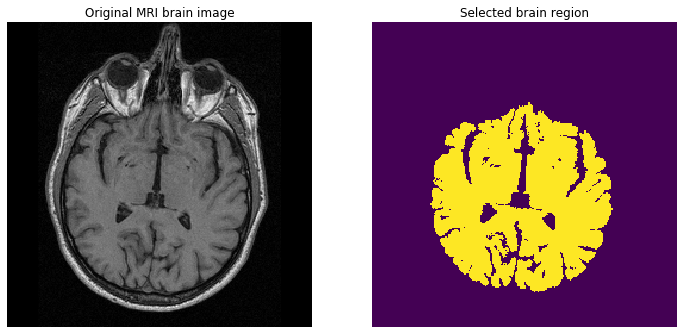

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# display original image
axs[0].imshow(brain_im, cmap='gray')
axs[0].set_title('Original MRI brain image')
axs[0].axis('off')

# display grown brain region
axs[1].imshow(good_brain_mask)
axs[1].set_title('Selected brain region')
axs[1].axis('off')

plt.show()


Finally, compute the size of the brain:

In [26]:
print("Number of pixels in brain:", np.sum(good_brain_mask))

Number of pixels in brain: 15861


### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [58]:
from scipy.signal import argrelextrema

In [4]:
data_path =  os.path.join(os.pardir, 'data', 'lab-01-data')

In [5]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


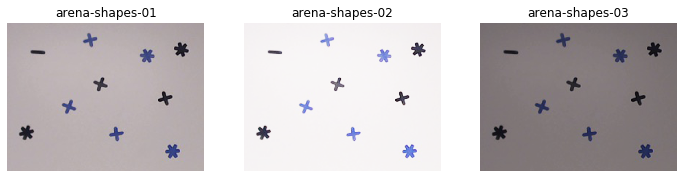

In [6]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [43]:
im2 = np.array([[v for v in l] for l in im])

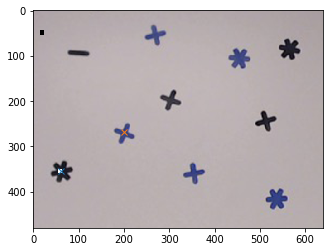

In [190]:
im2[350:360, 55:65, :] = 255
plt.figure()
plt.imshow(im2)
plt.plot([61], [355], marker="x")
plt.plot([200], [269], marker="x")

In [191]:
black = (355, 61)
blue = (269, 200)

In [152]:
from skimage import exposure

def normalize(im):
    # Contrast stretching
    p2, p98 = np.percentile(im, (2, 98))
    # p21, p981 = np.percentile(images[1], (3, 98))
    newim = exposure.rescale_intensity(im, in_range=(p2, p98))
    # newim2 = exposure.rescale_intensity(images[1], in_range=(p21, p981))

    # Plot images
    plt.figure()
    plt.imshow(newim, cmap='gist_rainbow') # 'gray'
    # ax[0].set_title('arena-shapes-01')

    # a.axis('off')
    # fig.tight_layout()

    # plt.show()
    return newim

In [177]:
# im = normalize(images[0])
im = images[2]
print(im.shape)
im_blue = im[:,:,2]
im_red = im[:,:,0]
im_green = im[:,:,1]

(480, 640, 3)


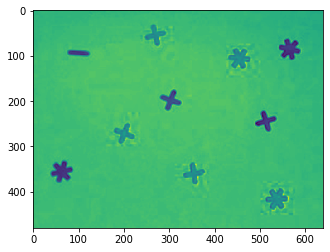

In [178]:
plt.figure()
plt.imshow(im_blue)

6 295.0
12 860.0


(0, 2500)

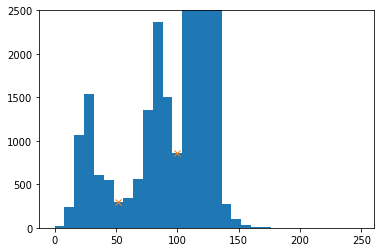

In [179]:
plt.figure()
nbs, vals, _ = plt.hist(im_blue.flatten(), bins=range(0,256,8))
max_bins = []
maxs = []
for i in argrelextrema(nbs, np.less)[0]:
    maxs.append(nbs[i])
    max_bins.append((vals[i] + vals[i+1])/2)
    print(i, nbs[i])
plt.plot(max_bins, maxs, ls='', marker="x")
plt.ylim(0,2500)

In [180]:
lims = [0] + max_bins
def which(val):
    for i in range(len(lims) - 1):
        if lims[i] <= val <= lims[i+1]:
            return i
    return i+1

In [181]:
mask = np.array(list(map(which, im_blue.flatten()))).reshape((480, 640))

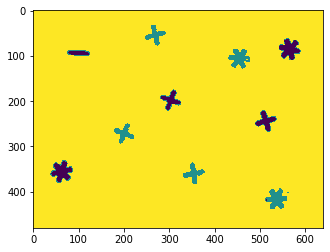

In [182]:
plt.figure()
plt.imshow(mask)

In [192]:
black_lab = mask[black]
blue_lab = mask[blue]

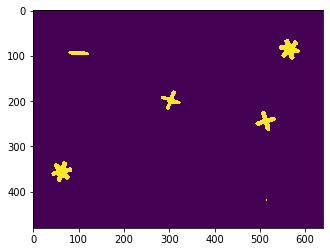

In [186]:
plt.figure()
plt.imshow(mask==black_lab)

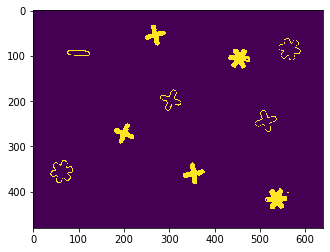

In [193]:
plt.figure()
plt.imshow(mask==blue_lab)

In [107]:
flattened = im.reshape((480*640, 3))

In [108]:
flattened#.reshape((480*640, 3))#.shape

array([[174, 163, 167],
       [174, 163, 167],
       [174, 163, 167],
       ...,
       [182, 173, 174],
       [182, 173, 174],
       [182, 173, 174]], dtype=uint8)

In [99]:
for x in im:
    for y in x:
        for v in y:
            print(v)

174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
173
162
166
173
162
166
172
161
165
172
161
165
172
161
166
172
161
167
172
161
167
173
162
168
173
162
168
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
174
163
169
175
164
170
175
164
170
175
164
170
175
164
170
174
164
169
173
164
169
173
164
169
173
164
169
173
164
169
173
164
169
173
164
169
173
164
169
174
165
170
174
165
170
174
165
170
174
165
170
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
175
166
171
174
165
170
174
165
170
174
165
170
174
165
170
174
165
170
175
166
171
175
166
172
176


166
176
166
167
176
166
167
176
166
167
176
166
167
176
166
167
176
166
167
176
166
167
176
166
166
176
166
165
177
166
165
177
167
166
177
167
166
176
166
167
175
166
167
175
166
167
176
167
168
176
167
168
177
168
169
177
168
169
177
168
169
177
168
169
177
168
169
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
170
179
169
170
179
169
170
178
170
169
178
170
168
177
170
167
177
169
167
177
169
168
177
168
168
177
168
169
178
168
170
178
169
170
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171
178
169
170
178
169
170
178
169
170
178
169
170
178
169
170
177
168
169
177
168
169
177
168
169
177
168
169
177
168
169
178
169
170
178
169
170
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171


171
178
169
172
178
169
172
178
169
172
178
169
172
177
168
171
177
168
171
177
168
171
178
169
172
178
169
172
179
170
173
179
170
173
179
170
173
178
169
172
177
168
171
176
167
170
176
167
170
177
168
171
178
169
172
179
170
172
179
170
172
179
170
172
179
170
172
179
170
172
178
169
171
178
169
170
178
169
170
178
169
170
178
169
170
178
169
170
178
169
170
178
169
170
178
169
170
178
169
170
177
168
169
177
168
169
177
168
169
177
168
169
177
168
169
177
168
169
177
168
169
178
169
170
178
169
170
178
170
169
178
170
168
178
170
168
178
170
168
178
170
168
177
169
167
177
169
167
177
169
167
177
169
167
177
169
168
178
168
168
178
168
169
179
168
170
179
169
170
180
170
171
180
170
171
180
170
171
179
169
170
179
169
170
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169


160
169
159
160
169
159
160
170
160
161
170
160
161
170
160
161
170
160
161
170
160
162
170
159
162
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
164
170
159
165
170
159
165
170
159
165
170
159
165
169
158
164
169
158
164
169
158
164
169
158
164
169
158
163
169
158
163
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
161
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
168
158
159
167
157
158
167
157
158
167
157
158
167
157
158
167
157
158
166
156
157
166
156
157
167
157
158
167
157
158
167
157
158
167
157
158
167
157
158
175
164
168
175
164
168
175
164
168
174
163
167
174
163
167
173
162
166
173
162
166
172
161
165
172
161
165
172
161
166
172
161
167
172
161
167
173
162
168
173
162
168
174
163
169
174
163
169
175
164
169
175
164
170
175
164
170


176
167
169
176
167
169
176
167
169
176
166
169
176
166
169
176
166
169
176
166
169
176
166
169
176
166
169
176
166
169
176
166
169
176
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
168
175
166
168
176
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
167
177
167
166
176
166
165
174
164
164
173
163
164
173
163
164
174
164
165
175
165
166
177
167
168
178
168
169
178
168
170
178
168
170
178
167
169
178
167
169
177
166
169
177
166
170
177
166
170
177
166
170
177
166
170
178
167
171
178
167
171
179
167
172
179
168
172
179
168
171
179


178
168
170
179
168
170
179
168
170
179
168
170
179
169
171
179
169
171
179
169
171
179
169
171
180
169
171
180
169
171
180
169
171
179
169
171
179
169
171
179
168
170
179
168
170
178
168
170
178
168
170
178
168
170
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
170
178
167
170
178
167
171
178
166
171
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169
175
164
168
175
164
168
175
164
168
175
164
168
175


163
172
162
163
173
163
164
173
163
164
173
163
164
173
163
164
173
163
164
173
163
164
173
163
164
173
163
164
173
163
164
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
171
161
162
171
161
162
171
161
162
171
161
162
171
161
163
171
160
163
171
160
164
171
160
164
171
160
164
171
160
164
170
159
163
170
159
163
170
159
163
170
159
163
171
160
164
171
160
164
171
160
164
171
160
164
171
160
164
171
160
164
171
160
164
170
159
164
170
159
163
170
159
162
170
160
161
170
160
161
171
161
161
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
163
171
160
163
171
160
164
170
159
164
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
161
169
159
160


170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
163
170
159
162
170
159
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
161
169
159
160
169
159
160
169
159
160
169
159
160
168
158
161
168
157
161
168
157
161
169
157
162
169
157
162
169
157
162
169
157
162
169
158
162
169
158
162
169
158
162
169
157
162
169
157
162
169
157
162
169
157
162
168
157
161
168
157
161
168
157
161
168
157
161
168
157
161
168
157
161
168
157
161
168
157
161
169
157
162
169
157
162
173
162
166
173
162
166
173
162
166
173
162
166
173
162
166
173
162
166
173
162
166
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
175
164
168
175
164
168
175
164
168
175
164
168
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177


167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
179
169
170
179
170
171
179
170
171
180
170
171
180
170
171
181
170
172
181
170
172
181
171
173
181
171
173
181
171
173
180
170
173
179
168
172
177
166
170
176
165
169
176
165
169
176
165
169
177
166
170
178
167
171
178
167
171
178
167
171
178
167
171
178
167
171
178
167
171
178
167
171
178
167
171
178
167
171
178
167
171
178
167
171
178
167


171
181
171
172
181
171
172
181
171
172
181
171
172
181
171
172
181
171
172
181
171
172
181
171
172
180
170
171
180
170
171
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
180
170
171
180
170
171
180
170
171
180
170
171
180
170
171
180
170
171
180
170
171
180
170
171
180
170
171
180
170
171
179
169
170
179
169
170
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
171
179
168
171
179
168
172
179
168
172
178
167
171
178
167
171
177
166
170
177
166
170
176
165
169
176
165
169
176
165
169
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
177
166
170
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169
176
165
169


170
175
164
170
174
163
169
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
173
162
166
173
162
166
173
162
167
174
163
167
174
163
166
174
164
165
174
164
165
174
164
165
174
164
165
174
164
165
174
164
165
174
164
165
173
163
164
173
163
164
173
163
164
173
163
164
172
162
163
172
162
163
172
162
163
173
163
164
173
163
164
173
163
164
173
163
164
173
163
164
173
163
164
173
163
164
172
162
163
172
162
163
173
163
164
173
163
164
173
163
164
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
172
162
163
171
161
162
170
160
161
170
160
161
170
160
161
172
162
163
173
163
164
173
163
164
172
162
163
172
162
163
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
171
161
162
172
162
163
172
162
163
172
162
163
171
161
162
171
161
163
171
160
163


163
170
159
163
170
159
163
170
159
163
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
159
162
170
160
161
170
160
161
170
160
161
170
160
161
169
159
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
169
158
162
168
157
161
168
157
161
168
157
161
168
157
161
168
157
161
175
164
168
175
164
168
174
163
167
174
163
167
174
163
167
175
164
168
175
164
168
176
165
169
176
165
169
176
165
169
175
164
168
175
164
168
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
174
163
167
175
164
168
175
164
168
176
165
169
176
165
169
177
166
170
177
166
170
177
166
170
176
166
170
176
166
170
176
166
170
176
166
170
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
175
166
169
176
167
170


177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
179
169
170
179
169
170
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
178
168
169
178
168
169
177
167
168
177
167
168
177
167
168
178
168
169
178
168
169
178
168
169
178
168
169
178
168
169
179
169
170
179
169
170
180
170
171
180
170
171
180
170
171
180
170
171
179
169
170
179
169
170
179
169
170
179
169
170
179
169
170
178
168
171
177
168
171
177
168
171
177
168
171
177
168
171
177
168
171
177
168
171
177
168
171
177


172
181
171
173
181
170
174
181
170
174
181
170
174
181
170
174
181
170
174
181
170
174
181
170
174
180
169
173
180
169
173
179
168
172
179
168
172
179
168
172
179
168
172
179
168
172
180
169
173
181
170
174
182
171
175
182
171
175
182
171
175
182
171
175
182
171
175
182
171
175
182
171
175
182
171
175
182
171
175
182
171
175
181
170
174
181
170
174
181
170
174
181
170
174
181
170
174
180
169
173
180
169
173
180
169
173
180
169
173
179
168
173
179
168
172
179
169
172
179
169
171
179
170
171
179
170
171
179
170
171
179
170
171
180
171
172
180
171
172
180
171
172
180
171
172
179
170
171
179
170
171
178
169
170
178
169
170
178
169
170
178
169
170
178
169
170
179
170
171
179
170
171
179
170
171
178
169
170
178
169
170
179
170
171
179
170
171
180
171
172
180
171
172
180
171
172
179
170
171
179
170
171
178
169
170
177
169
170
177
168
169
177
168
169
177
168
169
178
169
170
178
169
170
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171
179
170
171


KeyboardInterrupt: 

(array([1.00000e+01, 6.10000e+01, 2.44000e+02, 6.21000e+02, 1.14400e+03,
        6.70000e+02, 6.10000e+02, 1.08100e+03, 1.19500e+03, 1.22000e+03,
        8.29000e+02, 4.91000e+02, 4.25000e+02, 3.32000e+02, 2.84000e+02,
        2.97000e+02, 3.23000e+02, 2.73000e+02, 2.98000e+02, 3.15000e+02,
        3.15000e+02, 3.60000e+02, 4.14000e+02, 3.77000e+02, 6.17000e+02,
        9.78600e+03, 5.53060e+04, 1.50621e+05, 7.84870e+04, 1.94000e+02]),
 array([  300.        ,  2306.53333333,  4313.06666667,  6319.6       ,
         8326.13333333, 10332.66666667, 12339.2       , 14345.73333333,
        16352.26666667, 18358.8       , 20365.33333333, 22371.86666667,
        24378.4       , 26384.93333333, 28391.46666667, 30398.        ,
        32404.53333333, 34411.06666667, 36417.6       , 38424.13333333,
        40430.66666667, 42437.2       , 44443.73333333, 46450.26666667,
        48456.8       , 50463.33333333, 52469.86666667, 54476.4       ,
        56482.93333333, 58489.46666667, 60496.        ])

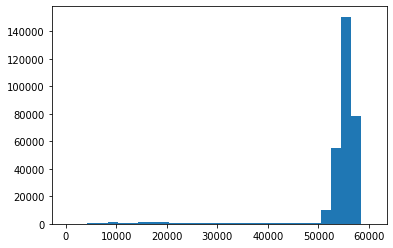

In [30]:
plt.figure()
plt.hist((im_blue + 300*im_red).flatten(), bins=30)   #  + 9000*im_green
#plt.ylim(0,20000)

(0, 20000)

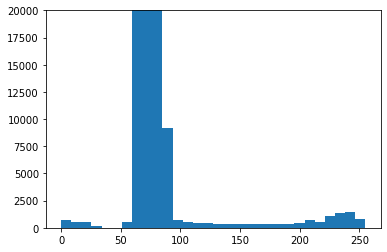

In [53]:
plt.figure()
plt.hist((im_blue-im_red-im_green).flatten(), bins=30)
plt.ylim(0,20000)

(0, 20000)

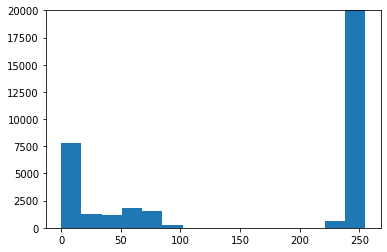

In [26]:
plt.figure()
plt.hist((im_blue-im_red).flatten(), bins=15)
plt.ylim(0,20000)

(0, 20000)

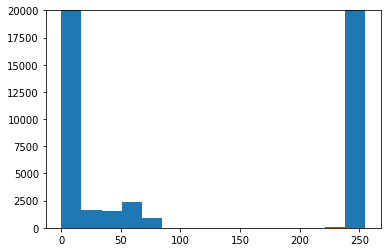

In [27]:
plt.figure()
plt.hist((im_blue-im_green).flatten(), bins=15)
plt.ylim(0,20000)

(array([1.19000e+02, 8.64000e+02, 1.77100e+03, 8.55000e+02, 1.60800e+03,
        2.58400e+03, 1.01200e+03, 5.95000e+02, 6.31000e+02, 5.91000e+02,
        6.94000e+02, 8.10000e+02, 2.09460e+04, 2.50312e+05, 2.38080e+04]),
 array([  0.        ,  12.86666667,  25.73333333,  38.6       ,
         51.46666667,  64.33333333,  77.2       ,  90.06666667,
        102.93333333, 115.8       , 128.66666667, 141.53333333,
        154.4       , 167.26666667, 180.13333333, 193.        ]),
 <a list of 15 Patch objects>)

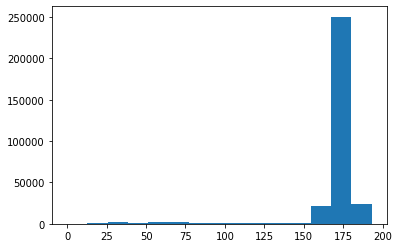

In [20]:
plt.hist(im_green.flatten(), bins=15)

(array([7.10000e+01, 8.65000e+02, 1.81000e+03, 1.69500e+03, 2.41500e+03,
        1.31700e+03, 7.60000e+02, 5.81000e+02, 5.93000e+02, 6.16000e+02,
        6.75000e+02, 7.78000e+02, 1.04160e+04, 2.05927e+05, 7.86810e+04]),
 array([  1.        ,  14.33333333,  27.66666667,  41.        ,
         54.33333333,  67.66666667,  81.        ,  94.33333333,
        107.66666667, 121.        , 134.33333333, 147.66666667,
        161.        , 174.33333333, 187.66666667, 201.        ]),
 <a list of 15 Patch objects>)

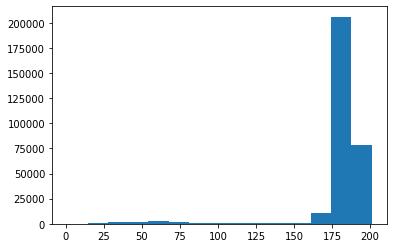

In [21]:
plt.hist(im_red.flatten(), bins=15)

### 2.2 Number of shapes of each color
Add your implementation and discussion

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion